# 前言
#### 数据源是来自[阿里云天池](https://tianchi.aliyun.com/dataset/142247)的3份世界杯数据集，分成3部分，每部分只对其中的一个数据集进行分析。

## part 1
#### WorldCupsSummary.csv 这个数据集是世界杯成绩信息数据，可供挖掘的纬度有举办年份、举办国家，指标则有总进球数、总参赛队伍数、现场观众总人数、总比赛场数、冠军队伍等。
### 1、数据理解与处理

In [1]:
import pandas as pd

df=pd.read_csv('WorldCupsSummary.csv',index_col=0) # 将第一列作为索引列
df.head()

,HostCountry,Winner,Second,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance,HostContinent,WinnerContinent
Year,,,,,,,,,,,
1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590549,America,America
1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363000,Europe,Europe
1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375700,Europe,Europe
1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1045246,America,America
1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768607,Europe,Europe


In [2]:
# 统一"Germany FR"和"Germany"
df=df.replace(['Germany FR'],['Germany'])
df.head()
# 数据预处理的主要涉及到数据清洗，以及针对我们要分析的问题进行特定字段的转化。本数据表比较干净，因此我们仅完成国家队名称的归一化处理。

,HostCountry,Winner,Second,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance,HostContinent,WinnerContinent
Year,,,,,,,,,,,
1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590549,America,America
1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363000,Europe,Europe
1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375700,Europe,Europe
1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1045246,America,America
1954,Switzerland,Germany,Hungary,Austria,Uruguay,140,16,26,768607,Europe,Europe


In [3]:
# 统计世界杯举办的年份
Year=list(df.index)
cnt={}
for i in range(1930,2019,4):
    cnt[str(i)]=(Year.count(i)==1)
cnt=pd.DataFrame([cnt]).T
cnt.columns=['是否举办']
cnt
# 1942、1946因战争停办两届

,是否举办
1930,True
1934,True
1938,True
1942,False
1946,False
1950,True
1954,True
1958,True
1962,True
1966,True


### 2、数据分析可视化
#### 2.1 夺冠次数分析

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts import options as opts
from pyecharts.charts import Map, Bar, Line,Pie, WordCloud,Grid

# 国家获得冠军数量
Winner=df.groupby(['Winner']).groups
for i in Winner:
    Winner[i]=len(Winner[i])
Winner=pd.DataFrame([Winner]).T
Winner.columns=['w']


# 国家获得亚军数量
Second=df.groupby(['Second']).groups
for i in Second:
    Second[i]=len(Second[i])
Second=pd.DataFrame([Second]).T
Second.columns=['s']

# 国家获得季军数量
Third=df.groupby(['Third']).groups
for i in Third:
    Third[i]=len(Third[i])
Third=pd.DataFrame([Third]).T
Third.columns=['t']

# 国家获得第四名数量
Fourth=df.groupby(['Fourth']).groups
for i in Fourth:
    Fourth[i]=len(Fourth[i])
Fourth=pd.DataFrame([Fourth]).T
Fourth.columns=['f']

Winner.reset_index(inplace=True)
Second.reset_index(inplace=True)
Third.reset_index(inplace=True)
Fourth.reset_index(inplace=True)
groupbyed=pd.merge(Winner,Second,how='outer',on='index')
groupbyed=pd.merge(groupbyed,Third,how='outer',on='index')
groupbyed=pd.merge(groupbyed,Fourth,how='outer',on='index')
groupbyed.columns=['国家','冠军数','亚军数','季军数','第四名数']
groupbyed.fillna(0,inplace=True)
groupbyed['总数']=groupbyed['冠军数']+groupbyed['亚军数']+groupbyed['季军数']+groupbyed['第四名数']
groupbyed.sort_values(by='冠军数',inplace=True,ascending=False)

c=(
    Bar(init_opts=opts.InitOpts(width='2000px'))
    .add_xaxis(list(groupbyed['国家']))
    .add_yaxis("冠军数",list(groupbyed['冠军数']),category_gap='15%')
    .add_yaxis("亚军数",list(groupbyed['亚军数']),category_gap='15%')
    .add_yaxis("季军数",list(groupbyed['季军数']),category_gap='15%')
    .add_yaxis("第四名数",list(groupbyed['第四名数']),category_gap='15%')
    .add_yaxis("总数",list(groupbyed['总数']),category_gap='15%')
    .set_global_opts(
                    title_opts=opts.TitleOpts(title="按照冠军数排序",pos_left='20%'),
                    datazoom_opts=opts.DataZoomOpts(),
                    xaxis_opts=opts.AxisOpts(name='国家',axispointer_opts={'interval':'0'},axislabel_opts=opts.LabelOpts(rotate=30,font_size=12)),
                    yaxis_opts=opts.AxisOpts(name='数量'),
                    legend_opts=opts.LegendOpts(textstyle_opts=opts.TextStyleOpts(font_size=15)))
)
c.render_notebook()

##### 可以看到巴西是夺冠次数最多的国家，德国、意大利两个国家紧随其后，分别是4次夺冠。进入半决赛最多的是德国队，其次就是巴西队、意大利队。


#### 2.2 地理位置分析

In [5]:
# 举办过世界杯的国家的分布
HostCountry=df.groupby(df.loc[:,'HostCountry']).groups
for i in HostCountry:
    HostCountry[i]=len(HostCountry[i])
HostCountry['Korea'],HostCountry['Japan']=1,1 # 日韩联合举办过一届世界杯
del HostCountry['Korea/Japan']
HostCountry['United States']=HostCountry['USA']
del HostCountry['USA']
HostCountry['United Kingdom']=HostCountry['England']
del HostCountry['England']
HostCountry=[[i,HostCountry[i]] for i in HostCountry]

c=(
    Map()
    .add(series_name="举办国家",data_pair=HostCountry,maptype="world")
    .set_global_opts(title_opts=opts.TitleOpts(title="世界地图"),visualmap_opts=opts.VisualMapOpts(max_=2,is_piecewise=False))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False,color='green'),showLegendSymbol=False)
)
c.render_notebook()

##### 可以看到亚洲、非洲举办过一次世界杯，法国、巴西、意大利等国家举办过两次，有的国家一次都没有举行。

In [6]:
# 获得过世界杯冠军的国家的分布
Winner=df.groupby(['Winner']).groups
for i in Winner:
    Winner[i]=len(Winner[i])
Winner['United Kingdom']=Winner['England']
del Winner['England']
Winner=[[i,Winner[i]] for i in Winner]

c=(
    Map()
    .add(series_name="夺冠国家",data_pair=Winner,maptype="world")
    .set_global_opts(title_opts=opts.TitleOpts(title="世界地图"),visualmap_opts=opts.VisualMapOpts(max_=5,is_piecewise=True))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False,color='green'),showLegendSymbol=False)
)
c.render_notebook()

##### 可以看到世界杯冠军国家都在南美和欧洲，巴西5次冠军，德国、意大利4次。


#### 2.3 赛况数据分析

In [7]:
GoalsScored=df.loc[:,'GoalsScored']
time=["{}".format(i) for i in list(GoalsScored.index)]
G_Average=np.array(GoalsScored)/np.array(df.loc[:,'MatchesPlayed'])
G_Average=[round(i,1) for i in G_Average]

bar=(
    Bar(init_opts=opts.InitOpts(width='2000px'))
    .add_xaxis(time)
    .add_yaxis("总进球数",GoalsScored.tolist(),category_gap='30%',z=0)
    .add_yaxis("总参赛队伍数",list(df.loc[:,"QualifiedTeams"]),category_gap='30%',z=0)
    .add_yaxis("总比赛场数",list(df.loc[:,'MatchesPlayed']),category_gap='30%',z=0)
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name='年'),
        yaxis_opts=opts.AxisOpts(name='个'),
        title_opts=opts.TitleOpts(title="历年赛况"),
        legend_opts=opts.LegendOpts(textstyle_opts=opts.TextStyleOpts(font_size=15))
    )
)

line=(
    Line()
    .add_xaxis(time)
    .add_yaxis("场均进球数",y_axis=G_Average,is_smooth=True,is_symbol_show=True)
)

bar.overlap(line)
grid=Grid()
grid.add(bar,opts.GridOpts(pos_left='5%',pos_right='5%'),is_control_axis_index=True)
grid.render_notebook()

##### 可以看出，世界杯参赛队伍从13支扩展到现在的32支，期间经历了两次队伍扩充，分别是1982年由16支队伍扩充到24支，以及1998年从24支扩充到32支，1938年和1950年队伍出现了减少的情况。随着世界杯参赛队伍的增多，导致比赛场次增加，比赛总进球数整体上呈上升趋势，但场均进球却在1954年达到了最大值。


#### 2.4 历年现场观众人数变化趋势

In [8]:
attendance=[round(i,2) for i in df.loc[:,'Attendance']/10000]
time=["{}".format(i) for i in list(df.index)]

c=(
    Line()
    .add_xaxis(time)
    .add_yaxis("现场观众总人数",attendance,is_smooth=True,
              markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_='max',symbol_size=[80,50],name='max'),
                                                     opts.MarkPointItem(type_='min',symbol_size=[80,50],name='min')]))
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(is_show=True,trigger="axis",axis_pointer_type="cross"),
        xaxis_opts=opts.AxisOpts(name='年',type_="category",axispointer_opts=opts.AxisPointerOpts(is_show=False,type_="shadow")),
        yaxis_opts=opts.AxisOpts(name='万人')
    )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)
c.render_notebook()

##### 可以看到，世界杯的现场观众总数整体呈上升趋势，从最初只有60万人到2018年有303万人现场观看，上涨了近5倍，其中在1934年现场观众最少，观众总数最多的一届是1994年的美国世界杯。

## part 2


#### WorldCupMatches.csv 这个数据集是世界杯比赛比分数据，可供挖掘的纬度有举办年份、比赛具体日期、举办城市等，指标则有主队名、客队名、现场观众数、比赛所属阶段、比赛裁判等。


### 1、数据理解与处理

In [9]:
data=pd.read_csv('WorldCupMatches.csv',index_col=0) # 将第一列作为索引列
data.head()

,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
Year,,,,,,,,,,,,,,,,,,
1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [10]:
data=data.replace(['Germany FR'],'Germany') # 统一“联邦德国”和“德国”

# 转换数据类型
data['Home Team Goals']=data['Home Team Goals'].apply(int)
data['Away Team Goals']=data['Away Team Goals'].apply(int)

# 格式化比赛结果
data['result']=data['Home Team Goals'].astype(str)+"-"+data['Away Team Goals'].astype(str)
data.head()

,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials,result
Year,,,,,,,,,,,,,,,,,,,
1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4,1,Mexico,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX,4-1
1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3,0,Belgium,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL,3-0
1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2,1,Brazil,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA,2-1
1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3,1,Peru,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER,3-1
1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1,0,France,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA,1-0


### 2、数据分析可视化
#### 2.1 现场观赛人数分析

In [11]:
data.loc[data['Stage'].str.contains('Group'),'Stage']='Group'
data.loc[data['Stage']=='First round','Stage']='Group'
data.loc[data['Stage']=='Preliminary round','Stage']='Group'
data.loc[data['Stage']=='Round of 16','Stage']='Quarter-finals'
data.loc[data['Stage']=='Third place','Stage']='Match for third place'
data.loc[data['Stage']=='Play-off for third place','Stage']='Match for third place'

Stage=list(set(data['Stage']))
Year=["{}".format(i) for i in list(set(data.index.astype(int)))]
Index={}
for i in Stage:
    a=[]
    for j in Year:
        a.append((j,i))
    Index[i]=a
    
groupbyed=data.groupby(['Year','Stage']).mean(numeric_only=True)

Index=[list(i) for i in groupbyed.index]
Index.sort(key=lambda x:x[1])
Final=[]
Group=[]
Third=[]
Quarter=[]
Semi=[]

Index=[tuple(i) for i in Index]
for i in Index:
    if i[1]=='Final':
        Final.append(i)
    elif i[1]=='Group':
        Group.append(i)
    elif i[1]=='Match for third place':
        Third.append(i)
    elif i[1]=='Quarter-finals':
        Quarter.append(i)
    else:
        Semi.append(i)

Group=groupbyed.loc[Group,'Attendance']
Quarter=groupbyed.loc[Quarter,'Attendance']
Semi=groupbyed.loc[Semi,'Attendance']
Third=groupbyed.loc[Third,'Attendance']
Final=groupbyed.loc[Final,'Attendance']
res=pd.merge(Group,Quarter,how='outer',on='Year')
res.rename(columns={'Attendance_x':'A'},inplace=True)
res.rename(columns={'Attendance_y':'Q'},inplace=True) # 避免res列名重复
res=pd.merge(res,Semi,how='outer',on='Year')
res=pd.merge(res,Third,how='outer',on='Year')
res=pd.merge(res,Final,how='outer',on='Year')
res.columns=['小组赛','16进8','半决赛','季军赛','决赛']
res.index=["{}".format(i) for i in list(set(res.index.astype(int)))]
for i in res.columns:
    print('未举办'+i+'的年份:',','.join(list(res[res[i].isna()][i].index)))
print("未举办某一比赛的观赛人数记为0")
c=(
    Line()
    .add_xaxis(Year)
    .add_yaxis("小组赛",res.iloc[:,0].fillna(0).astype(int).tolist(),is_connect_nones=True,is_smooth=True)
    .add_yaxis("16进8",res.iloc[:,1].fillna(0).astype(int).tolist(),is_connect_nones=True,is_smooth=True)
    .add_yaxis("半决赛",res.iloc[:,2].fillna(0).astype(int).tolist(),is_connect_nones=True,is_smooth=True)
    .add_yaxis("季军赛",res.iloc[:,3].fillna(0).astype(int).tolist(),is_connect_nones=True,is_smooth=True)
    .add_yaxis("决赛",res.iloc[:,4].fillna(0).astype(int).tolist(),is_connect_nones=True,is_smooth=True)
    .set_global_opts(title_opts=opts.TitleOpts(),
                    tooltip_opts=opts.TooltipOpts(is_show=True,axis_pointer_type="cross",trigger="axis"),
                    xaxis_opts=opts.AxisOpts(name='年'),
                    yaxis_opts=opts.AxisOpts(name='人'))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)
c.render_notebook()

未举办小组赛的年份: 
未举办16进8的年份: 1930,1950,1974,1978,1982
未举办半决赛的年份: 1950,1974,1978
未举办季军赛的年份: 1930,1950
未举办决赛的年份: 1950
未举办某一比赛的观赛人数记为0


##### 可以看出1950年世界杯仅举办了小组赛，推测是由于什么事件而影响了比赛进程。1986年世界杯决赛观赛人数最多，季军赛却很少（少于小组赛）。整体上看观赛人数普遍是决赛>季军赛>半决赛>16进8>小组赛。

#### 2.2 比赛进球、失球数分析

In [12]:
GS=pd.DataFrame(data.groupby(['Home Team Name']).sum(numeric_only=True)['Home Team Goals']+data.groupby(['Away Team Name']).sum(numeric_only=True)['Away Team Goals'])
GA=pd.DataFrame(data.groupby(['Home Team Name']).sum(numeric_only=True)['Away Team Goals']+data.groupby(['Away Team Name']).sum(numeric_only=True)['Home Team Goals'])
GS.index.names=['Team Name']
GA.index.names=['Team Name']

Goals=pd.merge(GS,GA,how='inner',on='Team Name')
Goals['Total Goals']=Goals.iloc[:,0]+Goals.iloc[:,1]
Goals.columns=['GS','GA','Total Goals']
Goals=Goals.sort_values(by='Total Goals',ascending=False)
Goals.fillna(0,inplace=True)

cnt1=data.groupby(['Home Team Name']).count()['Datetime']
cnt1.index.name='Team Name'
cnt2=data.groupby(['Away Team Name']).count()['Datetime']
cnt2.index.name='Team Name'

Goals=pd.merge(Goals,cnt1,how='inner',on='Team Name')
Goals=pd.merge(Goals,cnt2,how='inner',on='Team Name')
Goals['times']=Goals.iloc[:,3]+Goals.iloc[:,4]
Goals.drop(Goals.columns[[3,4]],axis=1,inplace=True)
Goals['GS_avg']=Goals.loc[:,'GS']/Goals.loc[:,'times']
Goals['GA_avg']=Goals.loc[:,'GA']/Goals.loc[:,'times']

c=(
    Bar(init_opts=opts.InitOpts(width='1600px'))
    .add_xaxis(Goals.index.tolist())
    .add_yaxis("总进球数",Goals.iloc[:,0].tolist())
    .add_yaxis("总失球数",Goals.iloc[:,1].tolist())
    .add_yaxis("总球数",Goals.iloc[:,2].tolist())
    .add_yaxis("场均进球数",[round(i,2) for i in Goals.iloc[:,4].tolist()])
    .add_yaxis("场均失球数",[round(i,2) for i in Goals.iloc[:,5].tolist()])
    .add_yaxis("总比赛场数",Goals.iloc[:,3].tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(),
        datazoom_opts=opts.DataZoomOpts(),
        xaxis_opts=opts.AxisOpts(name='Team Name'),
        yaxis_opts=opts.AxisOpts(name='Numbers')
    )
)
c.render_notebook()

##### 可以看出，历史进球最多的队伍依次是德国队、巴西队、阿根廷队和意大利队；历史场均进球最多的队伍依次是匈牙利、德国、巴西、土耳其。

In [13]:
# 冠军球队进球、失球数
tmp=df.groupby(['Winner']).groups
for i in tmp:
    tmp[i]=len(tmp[i])
tmp=pd.DataFrame([tmp]).T
tmp.columns=['nums']
tmp.sort_values(by='nums',ascending=False,inplace=True)
guanjun=tmp[tmp['nums']>=1].index
c=(
    Bar(init_opts=opts.InitOpts(width='1200px'))
    .add_xaxis(guanjun.tolist())
    .add_yaxis("总进球数",Goals.loc[guanjun,'GS'].tolist())
    .add_yaxis("总失球数",Goals.loc[guanjun,'GA'].tolist())
    .add_yaxis("总球数",Goals.loc[guanjun,'Total Goals'].tolist())
    .add_yaxis("场均进球数",[round(i,2) for i in Goals.loc[guanjun,'GS_avg'].tolist()])
    .add_yaxis("场均失球数",[round(i,2) for i in Goals.loc[guanjun,'GA_avg'].tolist()])
    .add_yaxis("总比赛场数",Goals.loc[guanjun,"times"].tolist())
    .add_yaxis("夺冠次数",tmp.loc[guanjun,"nums"].tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title='按照夺冠次数排名'),
        datazoom_opts=opts.DataZoomOpts(),
        xaxis_opts=opts.AxisOpts(name='Team Name'),
        yaxis_opts=opts.AxisOpts(name='Numbers')
    )
)
c.render_notebook()

##### 巴西、德国场均进球数大于2，意大利和英格兰场均失球数小于1。

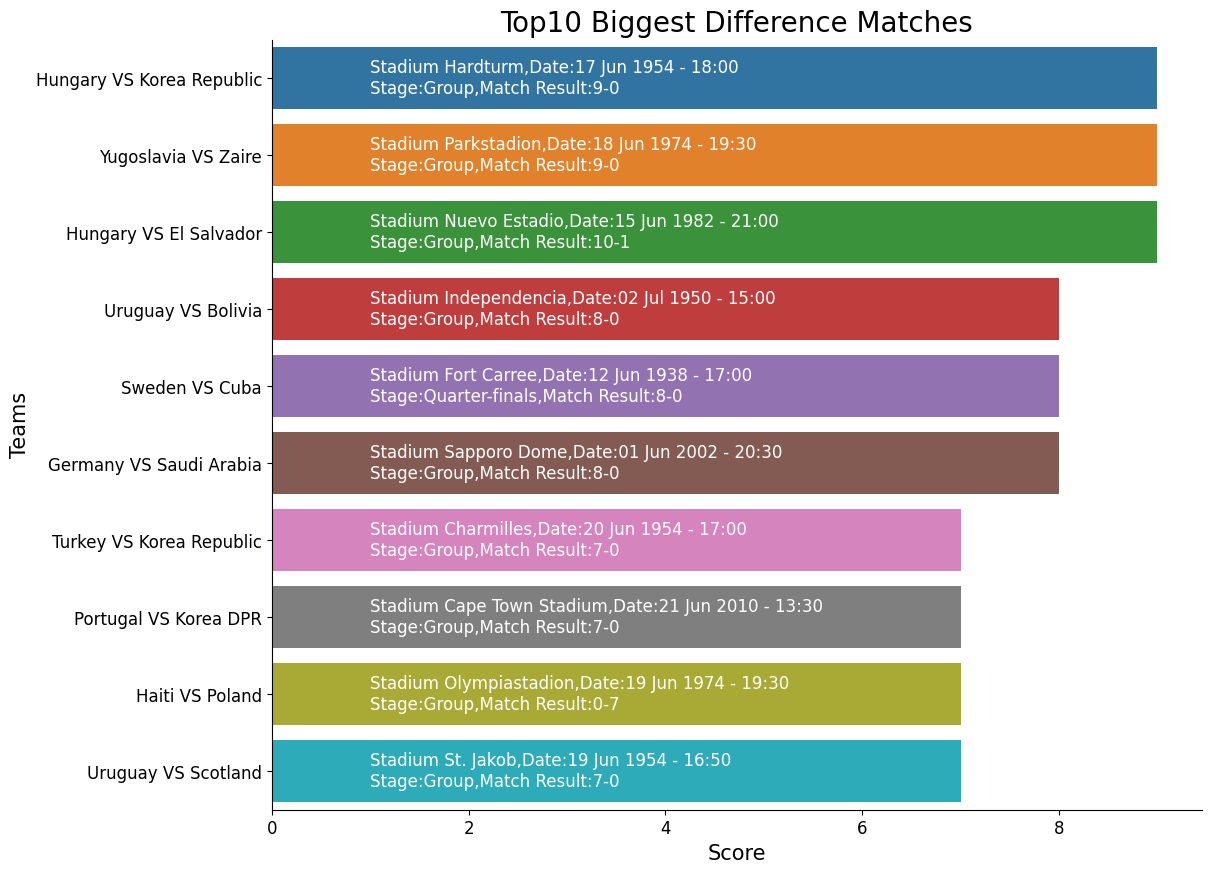

In [14]:
# 比分 Top10
data['maxGoals']=abs(data.loc[:,'Home Team Goals']-data.loc[:,'Away Team Goals'])
data.sort_values(by='maxGoals',ascending=False,inplace=True)
data['VS']=data.loc[:,'Home Team Name']+' VS '+data.loc[:,'Away Team Name']

plt.figure(figsize=(12,10))
ax=sns.barplot(y=data.iloc[:10,data.columns.get_loc('VS')],x=data.iloc[:10,data.columns.get_loc('maxGoals')])
sns.despine(right=True)
plt.ylabel('Teams',fontsize=15)
plt.xlabel('Score',fontsize=15)
plt.yticks(size=12)
plt.xticks(size=12)
plt.title('Top10 Biggest Difference Matches',size=20)

for i ,s in enumerate("Stadium "+data.iloc[:10,data.columns.get_loc('Stadium')]+",Date:"+data.iloc[:10,data.columns.get_loc('Datetime')]+"\n"+"Stage:"+data.iloc[:10,data.columns.get_loc('Stage')]+",Match Result:"+data.iloc[:10,data.columns.get_loc('result')]):
    ax.text(1,i,s,fontsize=12,color='white',va='center')
plt.show()

##### 可以看到，top10分差大的比赛都是聚集在小组赛阶段（stage：Group），只有一场是发生在16进8阶段。一般来说进入淘汰赛阶段，两队都会打得比较谨慎，发生大开大合比分的概率比较小。
#### 2.3 主客场分析

In [15]:
wins,draws,losse=0,0,0 # 主场队胜平负的次数
for i in data['result'].tolist():
    if int(i[0])>int(i[-1]):
        wins+=1
    elif int(i[0])==int(i[-1]):
        draws+=1
    else:
        losse+=1
x_data=['主场胜率','平局概率','客场胜率']
y_data=[wins,draws,losse]
data_pair=[list(i) for i in zip(x_data,y_data)]
data_pair.sort(key=lambda x: x[1])

c=(
    Pie(init_opts=opts.InitOpts(bg_color='#2c343c'))
    .add(
        series_name='概率',
        data_pair=data_pair,
        rosetype='radius',
        radius="60%",
        center=['50%','50%'],
        label_opts=opts.LabelOpts(is_show=False,position='center',color='#fff')
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="主客场胜率",
            pos_left='center',
            pos_top='5%',
            title_textstyle_opts=opts.TextStyleOpts(color='#fff')
        ),
        legend_opts=opts.LegendOpts(is_show=True,textstyle_opts=opts.TextStyleOpts(color='#fff'))
    )
    .set_series_opts(
        tooltip_opts=opts.TooltipOpts(trigger='item',formatter="{a} <br/>{b}: {c} ({d}%)"),
        label_ops=opts.LabelOpts(color='rgba(255,255,255,0.3)')
    )
)
c.render_notebook()

##### 可以看出，主场优势是真实存在的，主场胜率明显高于客场胜率。

#### 2.4 裁判分析

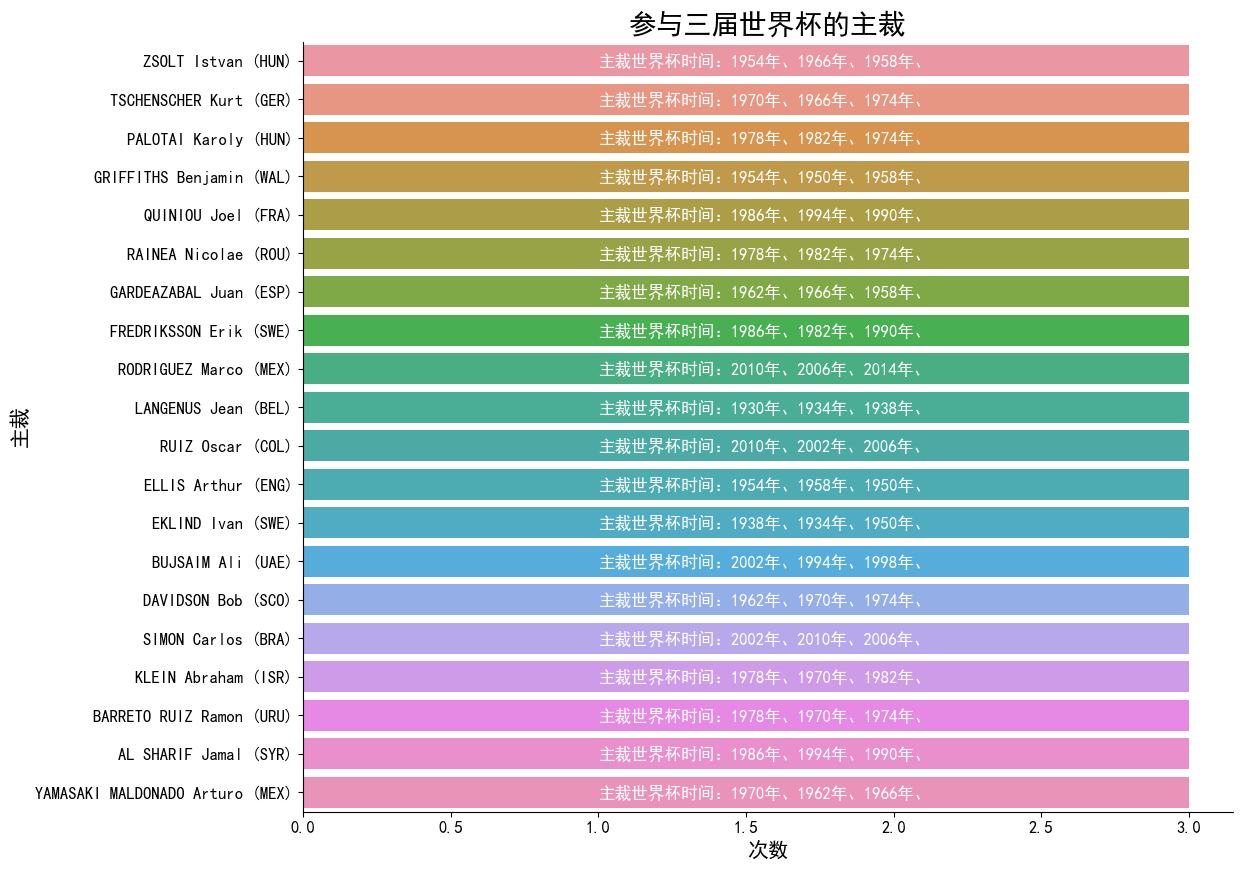

In [16]:
# 参与三届世界杯的主裁
Referee=data.groupby(['Referee']).groups
times=[]
for i in Referee:
    times.append(len(list(set(Referee[i]))))
    Referee[i]=list(set(Referee[i]))

Referee=pd.DataFrame().from_dict(Referee,orient='index')
Referee['Times']=times
Referee.index.name='Referee Name'
Referee.columns=['时间1','时间2','时间3','次数']
Referee.sort_values(by='次数',inplace=True,ascending=False)

plt.figure(figsize=(12,10))
plt.rcParams['font.sans-serif']=['SimHei']
ax=sns.barplot(y=Referee[Referee['次数']==3].index,x=Referee.loc[Referee[Referee['次数']==3].index,'次数'])
sns.despine(right=True)
plt.ylabel('主裁',fontsize=15)
plt.xlabel('次数',fontsize=15)
plt.yticks(size=12)
plt.xticks(size=12)
plt.title('参与三届世界杯的主裁',size=20)

for i,s in enumerate("主裁世界杯时间："+Referee.loc[Referee[Referee['次数']==3].index,'时间1'].astype(int).astype(str)+'年、'+Referee.loc[Referee[Referee['次数']==3].index,'时间2'].astype(int).astype(str)+'年、'+Referee.loc[Referee[Referee['次数']==3].index,'时间3'].astype(int).astype(str)+'年、'):
    ax.text(1,i,s,fontsize=12,color='white',va='center')
plt.show()

## part 3
#### WorldCupPlayers.csv 这个数据集是世界杯球员信息数据，可供挖掘的纬度有比赛ID，指标则有球衣号码、球员名、比赛角色等。
### 1、数据理解与处理

In [17]:
data2=pd.read_csv('WorldCupPlayers.csv') # 将第一列作为索引列
data2.head()

,RoundID,MatchID,Team Initials,Coach Name,Line-up,Shirt Number,Player Name,Position,Event
0,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Alex THEPOT,GK,NaN
1,201,1096,MEX,LUQUE Juan (MEX),S,0,Oscar BONFIGLIO,GK,NaN
2,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Marcel LANGILLER,NaN,G40'
3,201,1096,MEX,LUQUE Juan (MEX),S,0,Juan CARRENO,NaN,G70'
4,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Ernest LIBERATI,NaN,NaN


In [18]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   RoundID        37784 non-null  int64 
 1   MatchID        37784 non-null  int64 
 2   Team Initials  37784 non-null  object
 3   Coach Name     37784 non-null  object
 4   Line-up        37784 non-null  object
 5   Shirt Number   37784 non-null  int64 
 6   Player Name    37784 non-null  object
 7   Position       4143 non-null   object
 8   Event          9069 non-null   object
dtypes: int64(3), object(6)
memory usage: 2.6+ MB


### 2、数据分析可视化
#### 10号球员出场次数统计

In [48]:
Players=pd.value_counts(data2[data2['Shirt Number']==10]['Player Name'])
words=[]
for i in zip(Players.index,Players):
    words.append(i)
c=(
    WordCloud()
    .add('姓名',words,word_size_range=[6,66],textstyle_opts=opts.TextStyleOpts(font_family="cursive"))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="10号球员出场次数",title_textstyle_opts=opts.TextStyleOpts(font_size=23)),
        tooltip_opts=opts.TooltipOpts(is_show=True)
    )
)
c.render_notebook()

##### 从词云可以看出，梅西一共出场16次世界杯比赛。